In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import numpy as np

import vpfits

# Mock Spectrum

This randomly generated mock spectrum has multiple regions of absorption features that we want to fit.

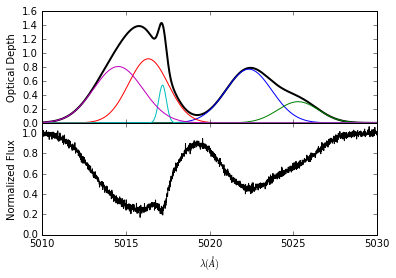

In [13]:
n = 5
clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True)

In [14]:
vpfit = vpfits.VPfit()
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))
flux_array = vpfit.Absorption(sum(clouds['tau'])) + noise

# Region Detection

Regions are detected based on a detection threshold of 4 sigma. The number of pixels needed below the threshold to divide regions is set with `buffer`, and the minimum width of a region is set with `min_region_width` in pixels.

The `compute_detection_regions` function outputs a numpy array of the start and end wavelengths of each region.

In [15]:
buffer = 3
min_region_width = 5
regions = vpfit.compute_detection_regions(wavelength_array, flux_array, noise, 
                                          buffer=buffer, min_region_width=min_region_width)
print(regions)

[[ 5010.36  5028.62]]


Note that a 10-pixel region of noise was selected as a detection region; this parameter needs to be properly tuned to avoid false regions.

In [16]:
region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(wavelength_array==region[0])[0][0]
    end = np.where(wavelength_array==region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([wavelength_array[start:end], flux_array[start:end]])

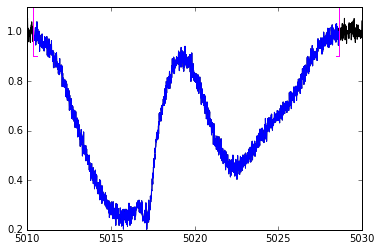

In [17]:
plt.plot(wavelength_array, flux_array, c='black')

for arr in region_arrays:
    plt.plot(arr[0], arr[1], color='blue')

def plot_bracket(x, dir):
    height = .2
    arm_length = 0.2
    plt.plot((x, x), (1-height/2, 1+height/2), color='magenta')
    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length
    plt.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    plt.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')
  
for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')
    
plt.show()

# Fitting Regions

Now we can loop over each region and run the main fitting routine separately on each region, finding the optimal number of profiles for each.

n:  2
Fit 1 BIC:  -887.638703122 , Fit 2 BIC:  -4093.26408493
BIC Ratio:  0.216853514629
n:  3
Fit 1 BIC:  -4093.26408493 , Fit 2 BIC:  -6919.23788283
BIC Ratio:  0.591577302912
n:  4
Fit 1 BIC:  -6919.23788283 , Fit 2 BIC:  -8018.80936992
BIC Ratio:  0.862875966198
n:  5
Fit 1 BIC:  -8018.80936992 , Fit 2 BIC:  -7969.88731085
BIC Ratio:  1.00613836271
n (final):  4
 [-----------------100%-----------------] 10000 of 10000 complete in 20.7 sec
Took: 0:00:20.713986  to finish.
36 1862


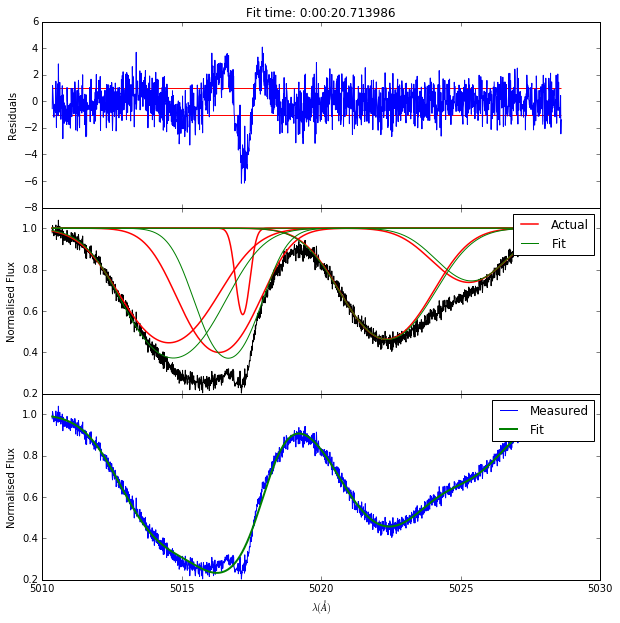

In [18]:
fits = []

for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelengths, fluxes, n)
    vpfit_2.map_estimate()

    while r < 1:

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n)
        vpfit_2.map_estimate()

        print "Fit 1 BIC: ", vpfit_1.MAP.BIC, ", Fit 2 BIC: ", vpfit_2.MAP.BIC
        print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC

        r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    n -= 1
    print "n (final): ", n
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    print start, end
    
    vpfit_1.plot(wavelengths, fluxes, clouds, n, start_pix=start, end_pix=end)

Finally, we can plot the detection regions and the fitted profiles over the entire spectrum.

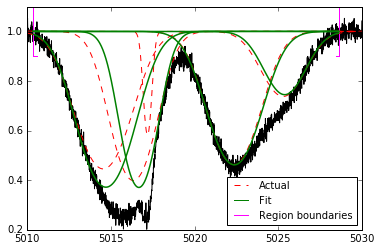

In [19]:
plt.plot(wavelength_array, flux_array, c='black')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')

for i in range(len(fits)):
    fit = fits[i]
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    for c in range(len(clouds)):
        plt.plot(wavelength_array, fit.Absorption(clouds.ix[c]['tau']), color="red", ls='--')
        
    for prof in fit.estimated_profiles:
        plt.plot(wavelengths, fit.Absorption(prof.value), color='green', lw=1.5)
        
plt.rcParams['figure.figsize'] = (10.0, 4.0)
handles = [mlines.Line2D([], [], color='red', label='Actual', ls='--'), mlines.Line2D([], [], color='green', label='Fit'),
          mlines.Line2D([], [], color='magenta', label='Region boundaries')]
plt.legend(handles=handles, prop={'size':10}, loc='best')
plt.show()